In [6]:
# import required packages and modules
import os
import sys
sys.path.insert(0,'../scripts/')

import pandas as pd
import numpy as np
from numpy import percentile

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import KMeans

# save model
import pickle

#
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go  
import matplotlib.pyplot as plt
from IPython.display import Image
from plotly.subplots import make_subplots
# 
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler, normalize

In [7]:
# Importing system  Scripts files
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from user_overview import UserOverview
from data_cleaning import DataFrameCleaning
from data_info import DataFrameInfo
from data_outliers import *
from plots import *

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [9]:
# Loading cleaned dataset

cleaned_data = pd.read_csv('../data/cleaned_dataset.csv')
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149001 entries, 0 to 149000
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      149001 non-null  int64  
 1   Unnamed:_0                      149001 non-null  int64  
 2   Bearer_Id                       149001 non-null  float64
 3   Start                           149001 non-null  object 
 4   Start_ms                        149001 non-null  float64
 5   End                             149001 non-null  object 
 6   End_ms                          149001 non-null  float64
 7   Dur._(ms)                       149001 non-null  float64
 8   IMSI                            149001 non-null  float64
 9   MSISDN_Number                   149001 non-null  float64
 10  IMEI                            149001 non-null  float64
 11  Last_Location_Name              149001 non-null  object 
 12  Avg_RTT_DL_(ms) 

# Experience Analytics
**Task 4.1.** - Aggregate, per customer, the following information(treat missing & outliers by replacing by the mean or the mode of the corresponding variable

In [10]:
user_experience_data = cleaned_data[[
    "MSISDN_Number",
    "Avg_RTT_DL_(ms)",
    "Avg_RTT_UL_(ms)",
    "Avg_Bearer_TP_DL_(kbps)",
    "Avg_Bearer_TP_UL_(kbps)",
    "Handset_Type"]].copy()

In [11]:
# Instantiate UserOverView class in user_overview

user_overview = UserOverview(user_experience_data)

In [12]:
# Convert Average RTT millisecond values to sec

user_experience_data['Avg_RTT_DL_(ms)'] = user_overview.convert_ms_to_sec(\
    user_experience_data['Avg_RTT_DL_(ms)'])

user_experience_data['Avg_RTT_UL_(ms)'] = user_overview.convert_ms_to_sec(\
    user_experience_data['Avg_RTT_UL_(ms)'])

In [13]:
# Bring back the deleted TCP Retransmission volume column during data cleaning from the original data 

df = pd.read_csv('../data/telecom.csv')
user_experience_data['TCP_DL_Retrans_Vol_(Bytes)'] = df['TCP DL Retrans. Vol (Bytes)']
user_experience_data['TCP_UL_Retrans_Vol_(Bytes)'] = df['TCP UL Retrans. Vol (Bytes)']

In [14]:
user_experience_data['TCP_DL_Retrans_Vol_(Bytes)'] = user_overview.convert_bytes_to_kbytes(\
    user_experience_data['TCP_DL_Retrans_Vol_(Bytes)'])

user_experience_data['TCP_UL_Retrans_Vol_(Bytes)'] = user_overview.convert_bytes_to_kbytes(\
    user_experience_data['TCP_UL_Retrans_Vol_(Bytes)'])

In [15]:
user_experience_data.rename(columns = {\
        'Avg_RTT_DL_(ms)':'Avg_RTT_DL_(sec)',\
        'Avg_RTT_UL_(ms)':'Avg_RTT_UL_(sec)',\
        'TCP_DL_Retrans_Vol_(Bytes)':'TCP_DL_Retrans_Vol_(kbps)',\
        'TCP_UL_Retrans_Vol_(Bytes)':'TCP_UL_Retrans_Vol_(kbps)'
    }, inplace=True)

In [16]:
# to check data information
user_experience_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149001 entries, 0 to 149000
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   MSISDN_Number              149001 non-null  float64
 1   Avg_RTT_DL_(sec)           149001 non-null  float64
 2   Avg_RTT_UL_(sec)           149001 non-null  float64
 3   Avg_Bearer_TP_DL_(kbps)    149001 non-null  float64
 4   Avg_Bearer_TP_UL_(kbps)    149001 non-null  float64
 5   Handset_Type               149001 non-null  object 
 6   TCP_DL_Retrans_Vol_(kbps)  61452 non-null   float64
 7   TCP_UL_Retrans_Vol_(kbps)  53030 non-null   float64
dtypes: float64(7), object(1)
memory usage: 9.1+ MB


In [17]:
# Handle null values of TCP Retransmission volume columns with mean and median based on Skewness value 

user_experience_data = DataFrameCleaning(user_experience_data)
columns = ['TCP_DL_Retrans_Vol_(kbps)', 'TCP_UL_Retrans_Vol_(kbps)']
user_experience_data.fill_numerical_column(columns)

Automation in Action...Great!!!


In [18]:
# Count null values if any

user_experience_data = DataFrameInfo(user_experience_data.df)
user_experience_data.get_null_counts()

MSISDN_Number                0
Avg_RTT_DL_(sec)             0
Avg_RTT_UL_(sec)             0
Avg_Bearer_TP_DL_(kbps)      0
Avg_Bearer_TP_UL_(kbps)      0
Handset_Type                 0
TCP_DL_Retrans_Vol_(kbps)    0
TCP_UL_Retrans_Vol_(kbps)    0
dtype: int64


In [19]:
# Convert dataframe object to dataframe

user_experience_data = user_experience_data.df

In [20]:
user_experience_data['Total_Avg_RTT'] = user_experience_data['Avg_RTT_DL_(sec)'] + \
                                      user_experience_data['Avg_RTT_UL_(sec)']

user_experience_data['Total_Avg_Bearer_TP'] = user_experience_data['Avg_Bearer_TP_DL_(kbps)'] + \
                                      user_experience_data['Avg_Bearer_TP_UL_(kbps)']

user_experience_data['Total_Avg_TCP'] = user_experience_data['TCP_DL_Retrans_Vol_(kbps)'] + \
                                      user_experience_data['TCP_DL_Retrans_Vol_(kbps)']
user_experience_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149001 entries, 0 to 149000
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   MSISDN_Number              149001 non-null  float64
 1   Avg_RTT_DL_(sec)           149001 non-null  float64
 2   Avg_RTT_UL_(sec)           149001 non-null  float64
 3   Avg_Bearer_TP_DL_(kbps)    149001 non-null  float64
 4   Avg_Bearer_TP_UL_(kbps)    149001 non-null  float64
 5   Handset_Type               149001 non-null  object 
 6   TCP_DL_Retrans_Vol_(kbps)  149001 non-null  float64
 7   TCP_UL_Retrans_Vol_(kbps)  149001 non-null  float64
 8   Total_Avg_RTT              149001 non-null  float64
 9   Total_Avg_Bearer_TP        149001 non-null  float64
 10  Total_Avg_TCP              149001 non-null  float64
dtypes: float64(10), object(1)
memory usage: 12.5+ MB


In [21]:
user_experience_agg = user_experience_data.groupby('MSISDN_Number').agg({
    'Total_Avg_RTT': 'sum',
    'Total_Avg_Bearer_TP': 'sum',
    'Total_Avg_TCP': 'sum',
    'Handset_Type': [lambda x: x.mode()[0]]})

user_experience = pd.DataFrame(columns=[
    "Total_Avg_RTT",
    "Total_Avg_Bearer_TP",
    "Total_Avg_TCP",
    "Handset_Type"])

user_experience["Total_Avg_RTT"] = user_experience_agg["Total_Avg_RTT"]['sum']
user_experience["Total_Avg_Bearer_TP"] = user_experience_agg["Total_Avg_Bearer_TP"]['sum']
user_experience["Total_Avg_TCP"] = user_experience_agg["Total_Avg_TCP"]['sum']
user_experience["Handset_Type"] = user_experience_agg["Handset_Type"]['<lambda>']
user_experience.head()

,Total_Avg_RTT,Total_Avg_Bearer_TP,Total_Avg_TCP,Handset_Type
MSISDN_Number,,,,
33601001722.00,0.05,76.00,1116.01,Huawei P20 Lite Huawei Nova 3E
33601001754.00,0.03,99.00,1116.01,Apple iPhone 7 (A1778)
33601002511.00,0.05,97.00,1116.01,undefined
33601007832.00,0.08,248.00,587.21,Apple iPhone 5S (A1457)
33601008617.00,0.12,56844.00,1119.51,Apple iPhone Se (A1723)


<Axes: >

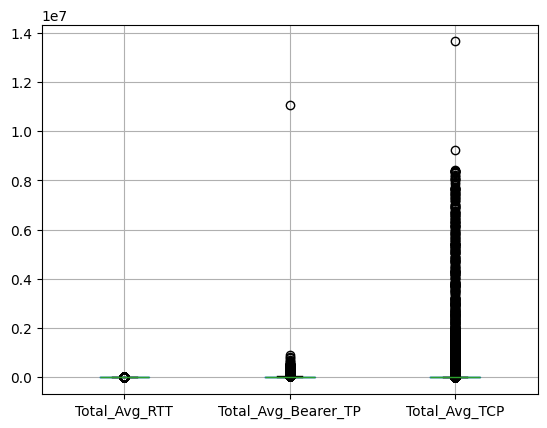

In [22]:
# displaying outlier
user_experience.boxplot()

In [23]:
# Remove Outliers

replace_outliers_with_iqr(user_experience, ['Total_Avg_RTT', 'Total_Avg_Bearer_TP', 'Total_Avg_TCP'])
user_experience.boxplot()

<Axes: >

###### Task 3.2 compute & list 10 of the top, bottom and most frequent
    a. TCP values in dataset
    b. RTT values in the dataset
    c. Throught values in the dataset
    

In [24]:
#Sort Dataset by TCP Values
sorted_by_tcp = user_experience_data.sort_values(
    'Total_Avg_TCP', ascending=False)
top_10 = sorted_by_tcp.head(10)['Total_Avg_TCP']
last_10 = sorted_by_tcp.tail(10)['Total_Avg_TCP']
most_10 = user_experience_data['Total_Avg_TCP'].value_counts().head(10)

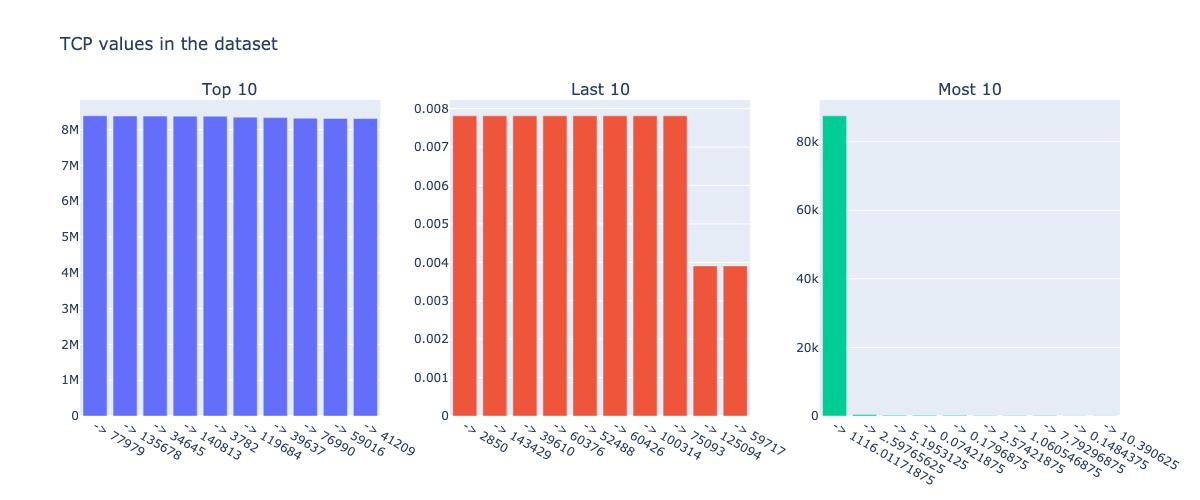

In [25]:
mult_hist([top_10, last_10, most_10], 1,
          3, "TCP values in the dataset", ['Top 10', 'Last 10', 'Most 10'])

In [26]:
#Sort Dataset by RTT Values
sorted_by_RTT = user_experience_data.sort_values(
    'Total_Avg_RTT', ascending=False)
top_10 = sorted_by_RTT.head(10)['Total_Avg_RTT']
last_10 = sorted_by_RTT.tail(10)['Total_Avg_RTT']
most_10 = user_experience_data['Total_Avg_RTT'].value_counts().head(10)

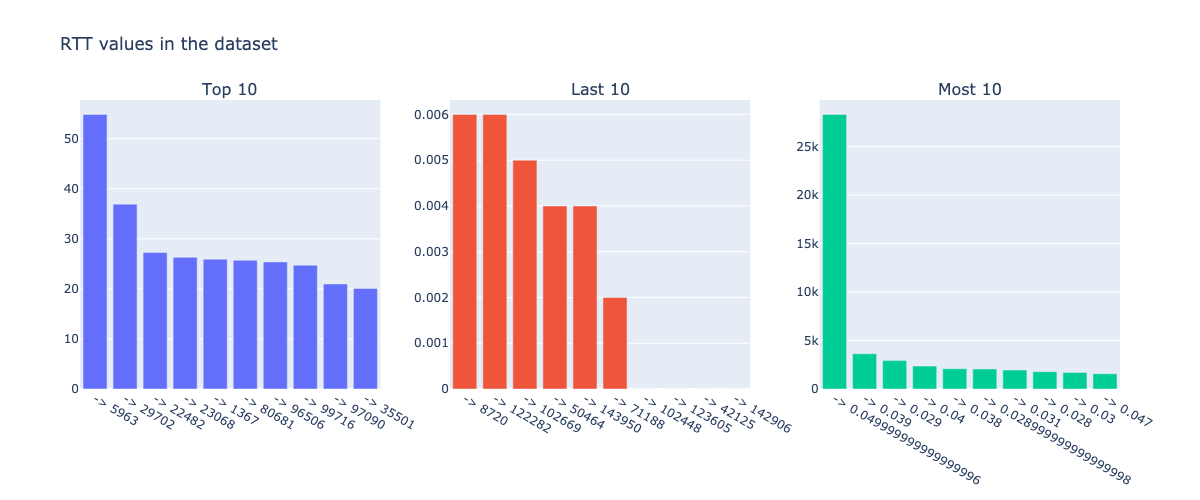

In [27]:
mult_hist([top_10, last_10, most_10, top_10], 1,
          3, "RTT values in the dataset", ['Top 10', 'Last 10', 'Most 10'])

In [28]:
#Sort Dataset by Throughput Values 
sorted_by_Bearer_TP = user_experience_data.sort_values(
    'Total_Avg_Bearer_TP', ascending=False)
top_10 = sorted_by_Bearer_TP.head(10)['Total_Avg_Bearer_TP']
last_10 = sorted_by_Bearer_TP.tail(10)['Total_Avg_Bearer_TP']
most_10 = user_experience_data['Total_Avg_Bearer_TP'].value_counts().head(10)

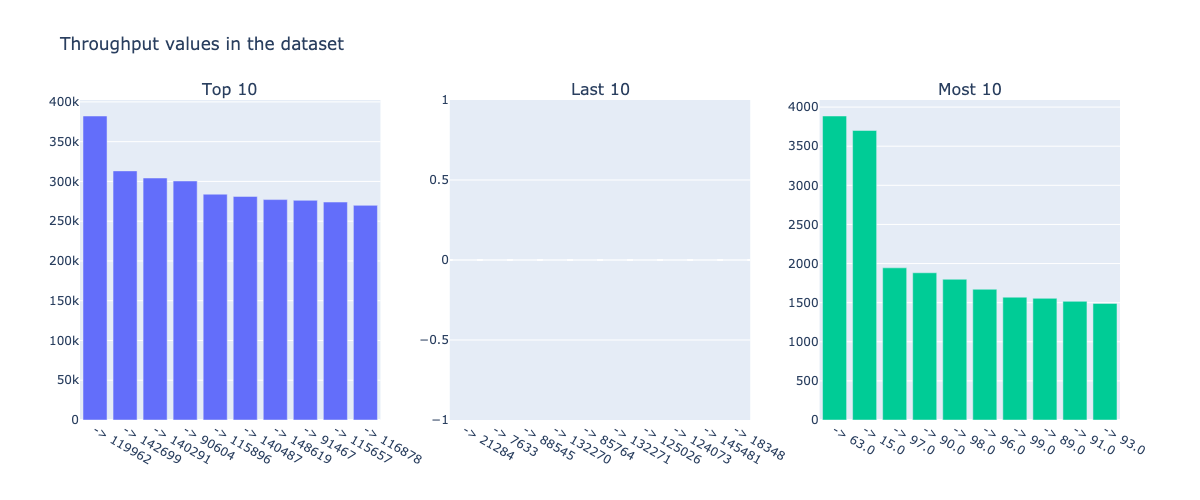

In [29]:
mult_hist([top_10, last_10, most_10, top_10], 1,
          3, "Throughput values in the dataset", ['Top 10', 'Last 10', 'Most 10'])

# **Task 3.3.** 
    d. Compute the distribution of the average throughput  per handset type 
    e. Compute the average TCP retransmission view per handset type 

In [30]:
handset_type_agg = user_experience_data.groupby('Handset_Type').agg(
    {'Total_Avg_Bearer_TP': 'mean', 'Total_Avg_TCP': 'mean'})
handset_type_agg.head()

,Total_Avg_Bearer_TP,Total_Avg_TCP
Handset_Type,,
A-Link Telecom I. Cubot A5,23510.00,3.51
A-Link Telecom I. Cubot Note Plus,6699.00,1116.01
A-Link Telecom I. Cubot Note S,8937.00,638.18
A-Link Telecom I. Cubot Nova,56217.00,164.78
A-Link Telecom I. Cubot Power,69468.00,1116.01


In [31]:
sorted_by_tp = handset_type_agg.sort_values('Total_Avg_Bearer_TP', ascending=False)
top_tp = sorted_by_tp['Total_Avg_Bearer_TP']
 
sns.distplot(top_tp)
pd.DataFrame(top_tp.describe()) 

,Total_Avg_Bearer_TP
count,1393.00
mean,12461.02
std,14726.71
min,0.00
25%,1390.00
50%,8628.67
75%,17403.76
max,108994.23


# **Task 3.4.** 
Perform a K-Means clustering (where k = 3) to segment users into groups of experiences.

In [32]:
experiance_metric_df = user_experience[[
    "Total_Avg_RTT",
    "Total_Avg_Bearer_TP",
    "Total_Avg_TCP"]].copy()
experiance_metric_df.head()

,Total_Avg_RTT,Total_Avg_Bearer_TP,Total_Avg_TCP
MSISDN_Number,,,
33601001722.00,0.05,76.00,1116.01
33601001754.00,0.03,99.00,1116.01
33601002511.00,0.05,97.00,1116.01
33601007832.00,0.08,248.00,587.21
33601008617.00,0.12,56844.00,1119.51


In [33]:
user_experience.boxplot()

<Axes: xlabel='Total_Avg_Bearer_TP', ylabel='Density'>

In [34]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(experiance_metric_df)
pd.DataFrame(scaled_array).head(5)

,0,1,2
0,-0.69,-0.66,-0.48
1,-0.93,-0.66,-0.48
2,-0.62,-0.66,-0.48
3,-0.08,-0.66,-0.90
4,0.47,1.78,-0.48


In [35]:
data_normalized = normalize(scaled_array)
pd.DataFrame(data_normalized).head(5)

,0,1,2
0,-0.64,-0.62,-0.45
1,-0.75,-0.54,-0.39
2,-0.61,-0.64,-0.47
3,-0.07,-0.59,-0.81
4,0.25,0.94,-0.25


In [36]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_normalized)
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [37]:
experiance_metric_df.insert(0, 'Cluster', kmeans.labels_)
experiance_metric_df.head(10)

,Cluster,Total_Avg_RTT,Total_Avg_Bearer_TP,Total_Avg_TCP
MSISDN_Number,,,,
33601001722.00,1,0.05,76.00,1116.01
33601001754.00,1,0.03,99.00,1116.01
33601002511.00,1,0.05,97.00,1116.01
33601007832.00,1,0.08,248.00,587.21
33601008617.00,0,0.12,56844.00,1119.51
33601010682.00,1,0.07,7908.00,1223.31
33601011634.00,2,0.05,42513.00,3906.04
33601011959.00,1,0.05,1247.00,128.17
33601014694.00,2,0.10,189.00,3906.04


In [38]:
experiance_metric_df['Cluster'].value_counts()

1    51524
0    33812
2    21135
Name: Cluster, dtype: int64

In [ ]:
fig = px.scatter(experiance_metric_df, x='Total_Avg_RTT', y="Total_Avg_Bearer_TP",
                 color='Cluster', size='Total_Avg_TCP')
fig.show()

In [40]:
#save the model
import pickle
with open("../models/user_experiance.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [41]:
experiance_metric_df.to_csv('../data/user_experiance.csv')